In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv

--2020-09-10 02:38:01--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv
Resolving raw.githubusercontent.com... 151.101.52.133
Connecting to raw.githubusercontent.com|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230924 (226K) [text/plain]
Saving to: 'oil-spill.csv'

oil-spill.csv       100%[===================>] 225.51K  --.-KB/s    in 0.05s   

2020-09-10 02:38:01 (4.52 MB/s) - 'oil-spill.csv' saved [230924/230924]



In [33]:
# load data
filename = 'oil-spill.csv'
df = pd.read_csv(filename, header=None)
print(df.shape)
# print(df.describe())
target = df.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f'Class = {k}, Count = {v}, Percentage = {round(per, 3)}%')

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


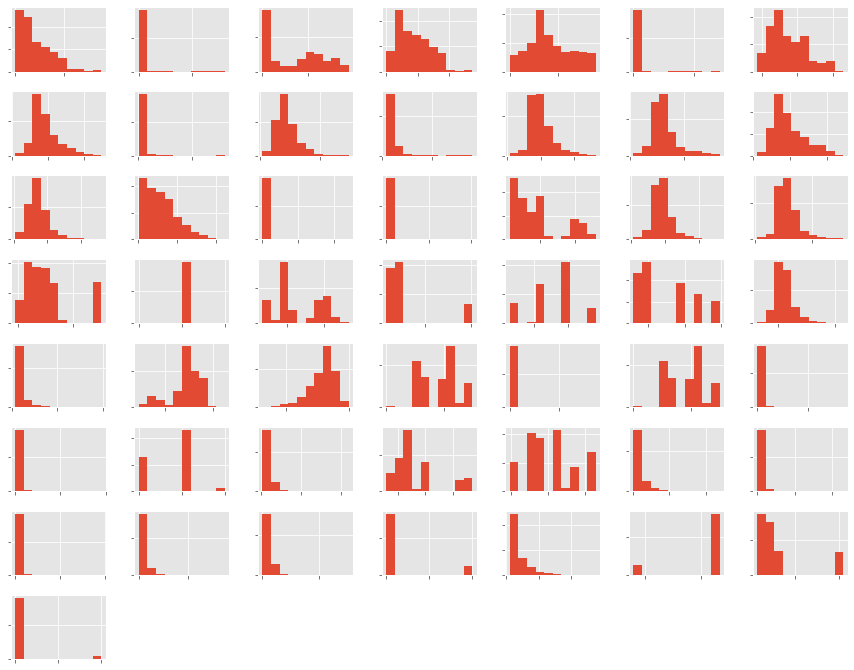

In [34]:
# visualization

ax = df.hist(figsize=(15, 12))
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
plt.show()

# Model Test and Baseline Result

Metics: Gmean = rsqt(sensitivity * specificity 

sensitivity = recall = true positive / (true positive + false negative) measure of the accuracy of positive class

specificity = true negative / (true negative + false positive) measure of the accuracy of negative class

In [35]:
## drop variable 1 that defines image ID, and column 22 which has one single number

df.drop([0, 22], axis=1, inplace=True)

In [43]:
from sklearn.preprocessing import LabelEncoder

In [48]:
data = df.values
X, y = data[:, :-1], data[:, -1]
y = LabelEncoder().fit_transform(y)

In [49]:
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_stats=1)
    metric = make_scorer(geometric_mean_score)
    scores = corss_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores